#  <center> Deep Learning <center>

# DNA binding sites

In [204]:
# Download data 
! wget https://raw.githubusercontent.com/wwang2/ML4MolEng/master/psets/ps3/data/train_dna.csv

--2021-04-06 01:12:16--  https://raw.githubusercontent.com/wwang2/ML4MolEng/master/psets/ps3/data/train_dna.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1408340 (1.3M) [text/plain]
Saving to: ‘train_dna.csv’

train_dna.csv       100%[===================>]   1.34M  --.-KB/s    in 0.02s   

2021-04-06 01:12:16 (60.4 MB/s) - ‘train_dna.csv’ saved [1408340/1408340]



In [205]:
import pandas as pd 
import torch
import numpy as np

train_pd = pd.read_csv("./train_dna.csv")

X = train_pd.seq.values
y = train_pd.bind.values


In [206]:
# Check if your GPU is requested successfully or not 
assert torch.cuda.device_count() != 0

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda:0 device


### 1.1 Build Datasets and DataLoaders in PyTorch

One-hot encode DNA sequence data 

In [207]:
# One-hot encode DNA sequence data

def one_hot_encode(seq):
    mapping = dict(zip("ACGT", range(4)))    
    seq2 = [mapping[i] for i in seq]
    return np.eye(4)[seq2]

XX = [one_hot_encode(X[i]) for i in range(len(X))]

# Transform  data from list to ndarray
XX = np.array(XX)


In [208]:
# Build Datasets
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Generate dataset 
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)  # store X as a pytorch Tensor
        self.y = torch.Tensor(y)  # store y as a pytorch Tensor
        self.len=len(self.X)      # number of samples in the data 

    def __getitem__(self, index):
        return self.X[index,:,:], self.y[index]

    def __len__(self):
        return self.len
    

Define your Datasets and DataLoaders 

In [209]:
from sklearn.model_selection import train_test_split

# Split dataset to train/val/test ( Ratios: 0.8*0.9 / 0.8*0.1 / 0.2 )
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

#Build dataset 
traindata = SequenceDataset(X=X_train, y=y_train)
valdata = SequenceDataset(X=X_val, y=y_val)
testdata = SequenceDataset(X=X_test, y=y_test)

# Build dataloader 
batchsize = 256
train_loader = DataLoader(dataset=traindata,batch_size=batchsize,shuffle=True)
val_loader = DataLoader(dataset=valdata,batch_size=batchsize,shuffle=True)
test_loader = DataLoader(dataset=testdata,batch_size=batchsize,shuffle=True)

In [ ]:
X_batch_list = [ batch[0] for index, batch in enumerate(train_loader) ]
y_batch_list = [ batch[1] for index, batch in enumerate(train_loader) ]

### 1.4 Build an LSTM-based binding classifier 

In [214]:
# Use torch.nn.LSTM module 
from torch import nn

# Define a LSTM module 
lstm_model = nn.LSTM(input_size=4, hidden_size=16, batch_first=True).to("cuda:0") # "cuda:0" is the device id

# Send your batch to a GPU 
X_batch = X_batch.to("cuda:0")
y_batch = y_batch.to("cuda:0")

# Propagate your batch into your model 
lstm_out, (ht, ct) = lstm_model(X_batch) 

In [215]:
# Define a MLP with a nn.Sequential that stacks nn.Linear and nn.ReLU()

mlp = nn.Sequential( nn.Linear(16, 16), 
                     nn.ReLU(),  
                     nn.Linear(16, 1)).to("cuda:0")
output = mlp(ht[-1])

# define a sigmoid module that maps the scalar output to a probability 
sigmoid = nn.Sigmoid()
proba = sigmoid(output)

In [216]:
# Use Cross-Entropy to compute a loss function

import torch.nn.functional as F

loss = F.binary_cross_entropy(proba.squeeze(), y_batch.squeeze()) # squeeze contruct the last dimension to make sure the dimensions match between y_batch and proba

print(loss)

tensor(0.6945, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


In [217]:
class LSTMseq(torch.nn.Module) :
    def __init__(self, input_dim, hidden_dim) :
        super().__init__()
        
        # define a lstm module
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True).to("cuda:0")
        
        # define a mlp regressor 
        self.mlp = nn.Sequential( nn.Linear(16, 16), 
                                  nn.ReLU(),  
                                  nn.Linear(16, 1)).to("cuda:0")
        
        # define a sigmod transform
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        
        # Apply lstm 
        lstm_out, (ht, ct) = self.lstm(x)
        # pass ouput into a MLP 
        output = self.mlp(ht[-1])
        # transform output into probabilites 
        proba = self.sigmoid(output) 
        # return probabilities 
        return proba

In [218]:
# Test your ouput on a batch 
clf = LSTMseq(input_dim=4, hidden_dim=16).to('cuda:0')


Implement functions for training and testing

In [219]:
from torch import nn
import torch.nn.functional as F

def train(model, dataloader, optimizer, device):
    
    '''
    A function train on the entire dataset for one epoch .
    
    Args: 
        model (torch.nn.Module()): your sequence classifier 
        dataloader (torch.utils.data.Dataloader): Dataloader object for the train data
        optimizer (torch.optim.Optimizer(()): optimizer object to interface gradient calculation and optimization 
        device (str): Your string
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    batch_loss = 0
    model.train() # Set model to training mode 
    
    size = len(dataloader)

    for batch in dataloader:
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        
        # Compute prediction error
        pred = model(seq)

        single_batch_loss = F.binary_cross_entropy(pred.squeeze(), label.squeeze())
        batch_loss += single_batch_loss

        # Backpropagation
        optimizer.zero_grad()
        single_batch_loss.backward()
        optimizer.step()
        
    batch_loss /= size

    return batch_loss


def validate(model, dataloader, device):
    
    '''
    A function validate on the validation dataset for one epoch .
    
    Args: 
        model (torch.nn.Module()): your sequence classifier 
        dataloader (torch.utils.data.Dataloader): Dataloader object for the train data
        device (str): Your string
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    size = len(dataloader)
    val_loss = 0
    model.eval() # Set model to evaluation mode 
    with torch.no_grad():    
        for batch in dataloader:
            seq, label = batch
            seq = seq.to(device)
            label = label.to(device)
            
            pred = model(seq)
            val_loss += F.binary_cross_entropy(pred.squeeze(), label.squeeze())
    
    val_loss /= size
    
    return val_loss

In [220]:
device = 'cuda:0'
model = LSTMseq(4, 16).to(device)

optimizer = torch.optim.Adam(list(model.parameters()), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, factor=0.5)

In [221]:
print("epoch", "train loss", "validation loss")

val_loss_curve = []
train_loss_curve = []

for epoch in range(500):
    
    # Compute train your model on training data
    epoch_loss = train(model, train_loader, optimizer, device=device)
    
    # Validate your on validation data 
    val_loss = validate(model, val_loader, device=device) 
    
    # Record train and loss performance 
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    
    # The learning rate scheduler record the validation loss 
    scheduler.step(val_loss)
    
    print(epoch, epoch_loss, val_loss)

epoch train loss validation loss
0 tensor(0.6935, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.6937, device='cuda:0')
1 tensor(0.6956, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.6918, device='cuda:0')
2 tensor(0.6925, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.6913, device='cuda:0')
3 tensor(0.6922, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.6896, device='cuda:0')
4 tensor(0.6912, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.6914, device='cuda:0')
5 tensor(0.6900, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.6845, device='cuda:0')
6 tensor(0.6891, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.6875, device='cuda:0')
7 tensor(0.6880, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.6909, device='cuda:0')
8 tensor(0.6879, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.6880, device='cuda:0')
9 tensor(0.6888, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.6838, device='cuda:0')
10 tensor(0.6871, device='cuda:0', grad_fn=<DivBackward0>) tensor(0

Plot train and test curve 

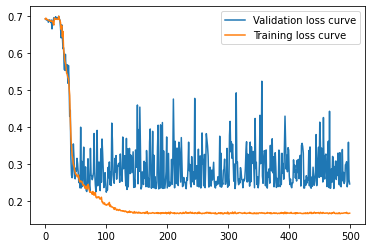

In [222]:
import matplotlib.pyplot as plt

plt.plot(val_loss_curve)
plt.plot(train_loss_curve)
plt.legend(['Validation loss curve', 'Training loss curve'])

Report AUC score on test data 

In [227]:
# Code to compute AUC on test data 
from sklearn.metrics import roc_auc_score

def test_AUC(model, dataloader, device):

  size = len(dataloader)
  test_score = 0
  model.eval() # Set model to evaluation mode
  
  for batch in dataloader:
    seq, label = batch
    seq = seq.to(device)
    
    pred = model(seq)
    test_score += roc_auc_score(label, pred.cpu().detach().numpy())
  
  test_score /= size
  return test_score

test_score = test_AUC(model, test_loader, device=device)

print("AUC on the test dataset is {}".format(test_score) ) 

AUC on the test dataset is 0.955923935730641


# Dimension Reductions for Molecular Representations

In [1]:
! wget https://raw.githubusercontent.com/wwang2/ML4MolEng/master/psets/ps3/data/drug.csv
! wget https://raw.githubusercontent.com/wwang2/ML4MolEng/master/psets/ps3/data/morgan.csv

--2021-04-06 03:53:35--  https://raw.githubusercontent.com/wwang2/ML4MolEng/master/psets/ps3/data/drug.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 314383 (307K) [text/plain]
Saving to: ‘drug.csv’

drug.csv            100%[===================>] 307.01K  --.-KB/s    in 0.02s   

2021-04-06 03:53:35 (17.8 MB/s) - ‘drug.csv’ saved [314383/314383]

--2021-04-06 03:53:35--  https://raw.githubusercontent.com/wwang2/ML4MolEng/master/psets/ps3/data/morgan.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59251200 (57M) [text/plai

In [2]:
import pandas as pd 
import torch
import numpy as np

# Check if your GPU is requested successfully or not 
assert torch.cuda.device_count() != 0

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# load data 
df = pd.read_csv("drug.csv")
fp = np.loadtxt('morgan.csv', delimiter=',')

assert fp.shape[0] == df.shape[0]

print(fp.shape)
print(df.shape)


Using cuda:0 device
(4629, 512)
(4629, 3)


### 2.1 Principal Component Analysis on Molecular Fingerprints

perform PCA to reduce data into vectors of 100 dimensions 

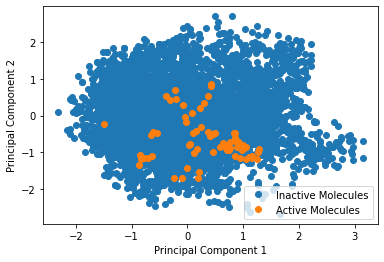

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=100)
fp_tr = pca.fit_transform(fp)

is_active_fp_tr = fp_tr[df['is_active'].iloc[:]==1]
is_not_active_fp_tr = fp_tr[df['is_active'].iloc[:]==0]

comp1 = 0
comp2 = 1
plt.plot(is_not_active_fp_tr[:,comp1], is_not_active_fp_tr[:,comp2], 'o', label='Inactive Molecules')
plt.plot(is_active_fp_tr[:,comp1], is_active_fp_tr[:,comp2], 'o', label='Active Molecules')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()


From the 2D scatter plot it seems like the majority of active drugs
have a positive value for the first principal component and a negative value
for the second principal component.
Therefore, we can say that the original characterstics of active drugs
will likely be summarized into some new characteristics that have 
a positive first and a negative second principle component.


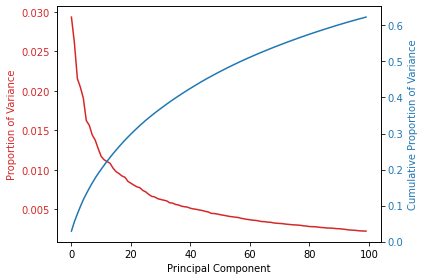

In [5]:
# Patterns in the distribution of active drugs from the 2D scatter plot
# of the first 2 principal components.
print('''From the 2D scatter plot it seems like the majority of active drugs
have a positive value for the first principal component and a negative value
for the second principal component.
Therefore, we can say that the original characterstics of active drugs
will likely be summarized into some new characteristics that have 
a positive first and a negative second principle component.''')

cum_sum = np.cumsum(pca.explained_variance_ratio_)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Variance', color=color)
ax1.plot(pca.explained_variance_ratio_[:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Cumulative Proportion of Variance', color=color)  # we already handled the x-label with ax1
ax2.plot(cum_sum, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()


### 2.2 T-SNE analysis on Molecular Fingerprints

Perform t-SNE anaylsis on the obtained principal components with three different perplexity values: 2, 50, 500

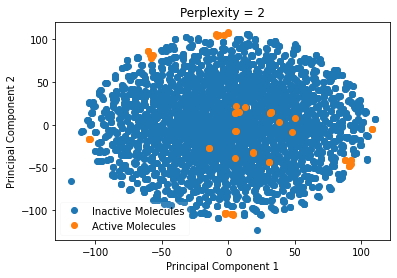

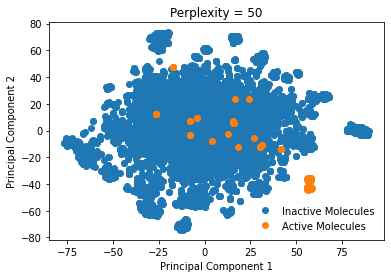

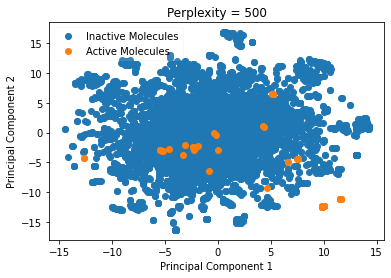

In [95]:
from sklearn.manifold import TSNE

tsne2 = TSNE(n_components=2, perplexity=2.0).fit_transform(fp_tr)
tsne50 = TSNE(n_components=2, perplexity=50.0).fit_transform(fp_tr)
tsne500 = TSNE(n_components=2, perplexity=500.0).fit_transform(fp_tr)

is_active_tsne2 = tsne2[df['is_active'].iloc[:]==1]
is_not_active_tsne2 = tsne2[df['is_active'].iloc[:]==0]

is_active_tsne50 = tsne50[df['is_active'].iloc[:]==1]
is_not_active_tsne50 = tsne50[df['is_active'].iloc[:]==0]

is_active_tsne500 = tsne500[df['is_active'].iloc[:]==1]
is_not_active_tsne500 = tsne500[df['is_active'].iloc[:]==0]

comp1 = 0
comp2 = 1

fig1, ax1 = plt.subplots()
ax1.plot(is_not_active_tsne2[:,comp1], is_not_active_tsne2[:,comp2], 'o', label='Inactive Molecules')
ax1.plot(is_active_tsne2[:,comp1], is_active_tsne2[:,comp2], 'o', label='Active Molecules')
ax1.set_title("Perplexity = 2")
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.legend(framealpha=0.1)

fig2, ax2 = plt.subplots()
ax2.plot(is_not_active_tsne50[:,comp1], is_not_active_tsne50[:,comp2], 'o', label='Inactive Molecules')
ax2.plot(is_active_tsne50[:,comp1], is_active_tsne50[:,comp2], 'o', label='Active Molecules')
ax2.set_title("Perplexity = 50")
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.legend(framealpha=0.1)

fig3, ax3 = plt.subplots()
ax3.plot(is_not_active_tsne500[:,comp1], is_not_active_tsne500[:,comp2], 'o', label='Inactive Molecules')
ax3.plot(is_active_tsne500[:,comp1], is_active_tsne500[:,comp2], 'o', label='Active Molecules')
ax3.set_title("Perplexity = 500")
ax3.set_xlabel('Principal Component 1')
ax3.set_ylabel('Principal Component 2')
ax3.legend(framealpha=0.1)

plt.show()


### 2.3 Interpretation of low dimensional embeddings

Split the data into 10 folds. For each fold, train on the other 9 folds and validate.

In [98]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

num_splits = 10

kf = KFold(n_splits=num_splits, shuffle=True)

active_label = df['is_active'].to_numpy()

X_train=[]
X_test=[]
y_train=[]
y_test=[]

fold_train_idx = []
fold_test_idx = []

for train_index, test_index in kf.split(fp):
  # Some book-keeping on the shuffled indices
  fold_train_idx.append(train_index)
  fold_test_idx.append(test_index)

  # Split data
  X_train.append(tsne50[train_index])
  X_test.append(tsne50[test_index])
  
  y_train.append(active_label[train_index])
  y_test.append(active_label[test_index])


pred_label = []
clf = []

for idx in range(num_splits):
  clf.append(RandomForestClassifier(n_estimators=100, max_depth=2))
  clf[idx].fit(X_train[idx], y_train[idx])

  pred_label.append(clf[idx].predict(X_test[idx]))


In [100]:

classifier = []
TP = []
FP = []
FN = []
TN = []

for split in range(num_splits):
  for i, idx in enumerate(fold_test_idx[split]):

    if pred_label[split][i]==1:
      if y_test[split][i]==1:
        classifier.append([idx, tsne50[idx][0], tsne50[idx][1], 'TP'])
        TP.append([tsne50[idx][0], tsne50[idx][1]])
      else:
        classifier.append([idx, tsne50[idx][0], tsne50[idx][1], 'FP'])
        FP.append([tsne50[idx][0], tsne50[idx][1]])
    else:
      if y_test[split][i]==1:
        classifier.append([idx, tsne50[idx][0], tsne50[idx][1], 'FN'])
        FN.append([tsne50[idx][0], tsne50[idx][1]])
      else:
        classifier.append([idx, tsne50[idx][0], tsne50[idx][1], 'TN'])
        TN.append([tsne50[idx][0], tsne50[idx][1]])

classifier.sort(key = lambda i: i[0])


The number of True Positives is:  47
The number of False Positives is:  0
The number of True Negatives is:  4550
The number of False Negatives is:  32


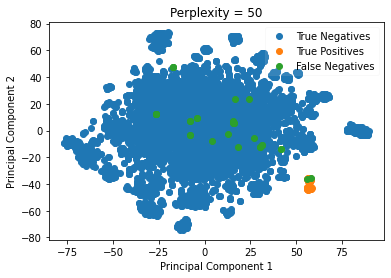

In [101]:

TP = np.array(TP)
FP = np.array(FP)
FN = np.array(FN)
TN = np.array(TN)

print("The number of True Positives is: ", len(TP))
print("The number of False Positives is: ", len(FP))
print("The number of True Negatives is: ", len(TN))
print("The number of False Negatives is: ", len(FN))

comp1 = 0
comp2 = 1

fig1, ax1 = plt.subplots()
ax1.plot(TN[:,comp1], TN[:,comp2], 'o', label='True Negatives')
ax1.plot(TP[:,comp1], TP[:,comp2], 'o', label='True Positives')
ax1.plot(FN[:,comp1], FN[:,comp2], 'o', label='False Negatives')

if FP.size > 0:
  ax1.plot(FP[:,comp1], FP[:,comp2], 'o', label='False Positives')

ax1.set_title("Perplexity = 50")
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.legend(framealpha=0.1)

plt.show()